In [17]:
import cli
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import emulators

from copy import deepcopy
from emulators import autocalc_lengthscale_bounds
from multiprocessing import Pool
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.reload_library()
plt.style.use('science')

detup = lambda x: str(x).replace('(','').replace(')','').replace(', ','-').replace("'","").replace("\'", "\"")

FANCY_NAMES = {
    'space+time+process'    : 'Space/time/process coordinates',
    'time+process'          : 'Time/process coordinates',
    'process'               : 'Process coordinates',
    'vi'    : 'VI',
    'mcmc'  : 'MCMC',
    'map'   : 'MAP gradient ascent',
    'sir'     : 'SIR model',
    'couzin'  : 'Couzin model',
    'kauffman': 'Kauffman network'
}

### Script settings

In [18]:
DRY_RUN      = False
model_types  = ['time+process']
datasets     = ['sir','couzin','kauffman']
white_noise  = True
return_model = False
run_parallel = False

response_transform = 'none'
data_dir           =  '../data/processed-emulator-inputs/'

### Prep list of inputs

In [19]:
if DRY_RUN:
    max_t = 2
    mcmc_iter = 10
else:
    max_t     = 1000
    mcmc_iter = 2000
    
modeling_fns = []    
run_tuples   = []
for dataset in datasets:
    input_filepath    = f'{data_dir}/{dataset}.json'
    for fit_method in ['mcmc']:
        for model_type in model_types:
            run_tuples += [(dataset, model_type, fit_method)]
            
finished_tuples = []
predictions     = {}

In [20]:
igp_inputs = {}
for tup in run_tuples:
    dataset, model_type, _ = tup
    run_string = f'{dataset}_{model_type}_{fit_method}'
    input_filepath = f'{data_dir}/{dataset}.json'
    inputs =  cli.prep_data(input_filepath, model_type, 
                            response_transform='none',
                            train_only=False)

    kron_Xs, y, offset, scale, input_scales, input_offsets, train, test = inputs

    kron_Xs_train     = deepcopy(kron_Xs)
    kron_Xs_train[-1] = kron_Xs[-1][train]

    kron_Xs_test     = deepcopy(kron_Xs)
    kron_Xs_test[-1] = kron_Xs[-1][test]

    timesteps, X_train = kron_Xs_train

    n_process_train   = len(X_train)
    n_process_total   = len(kron_Xs[-1])
    n_timesteps       = len(timesteps)

    y = y.reshape(n_timesteps, n_process_total).T
    ys_train = y[train, 0:max_t]
    ys_test  = y[test,0:max_t]

    Xs = [X_train for t in timesteps[0:max_t]]

    igp_inputs[tup] = {
        'Xs_train' : [kron_Xs_train[-1] for t in timesteps],
        'Xs_test'  : [kron_Xs_test[-1] for t in timesteps],
        'ys_train' : ys_train,
        'ys_test'  : ys_test,
        'offset'   : offset,
        'scale'    : scale
    }
    print(tup,'\n\tTraining shape: ', ys_train.shape, '\n\tTest shape: ', ys_test.shape)

2022-02-10 17:20:31 CRITICAL Response variable with shape (80, 200) standardized with mapping none, scale=9942 and offset=0
2022-02-10 17:20:31 CRITICAL Response variable with shape (100, 121) standardized with mapping none, scale=0.9481236246869191 and offset=0.0500507885142148
2022-02-10 17:20:31 CRITICAL Response variable with shape (40, 100) standardized with mapping none, scale=0.509 and offset=0.0


('sir', 'time+process', 'mcmc') 
	Training shape:  (127, 80) 
	Test shape:  (100, 80)
('couzin', 'time+process', 'mcmc') 
	Training shape:  (90, 100) 
	Test shape:  (31, 100)
('kauffman', 'time+process', 'mcmc') 
	Training shape:  (50, 40) 
	Test shape:  (50, 40)


### Running checks on input data

In [21]:
for key, d in igp_inputs.items():
    print(key)
    ymin, ymax = d['ys_train'].min(), d['ys_train'].max()
    print(f'\tValue range for ys_train : {ymin:.2f},{ymax:.2f}')
    
    ymin, ymax = d['ys_test'].min(), d['ys_test'].max()
    print(f'\tValue range for ys_test  : {ymin:.2f},{ymax:.2f}')
    print('scale:', d['scale'],' offset:',d['offset'])


('sir', 'time+process', 'mcmc')
	Value range for ys_train : 0.00,0.99
	Value range for ys_test  : 0.00,1.00
scale: 9942  offset: 0
('couzin', 'time+process', 'mcmc')
	Value range for ys_train : 0.00,1.00
	Value range for ys_test  : 0.04,1.00
scale: 0.9481236246869191  offset: 0.0500507885142148
('kauffman', 'time+process', 'mcmc')
	Value range for ys_train : 0.00,1.00
	Value range for ys_test  : 0.00,1.00
scale: 0.509  offset: 0.0


In [22]:
test_preds = {}


### Running individual models

In [23]:
for tup, inputs_dict in igp_inputs.items():

    t = 0

    T = inputs_dict['ys_train'].shape[-1]

    mu  = []
    var = []

    for t in range(T):
        print(t)
        X = inputs_dict['Xs_train']
        y = inputs_dict['ys_train'][:, t]

        X_test = inputs_dict['Xs_train']

        _, n_local_dims = X[0].shape

        lower, upper = [x[0] for x in autocalc_lengthscale_bounds(X[0:1])]

        y_scale = y.max()
        y_std = y / y_scale

        with pm.Model() as model:
            mean      = pm.Normal('mean', sd=1)
            gp_scale = pm.HalfNormal('gp_scale', sd=1.0)
            gp_variance = pm.Deterministic('gp_variance', gp_scale**2)
            mean_func = pm.gp.mean.Constant(mean)

            ls = pm.Uniform('ls', lower=lower, upper=upper)
            sigma = pm.HalfNormal('sigma', sd=1.)
            cov_fn = gp_variance * pm.gp.cov.Matern52(n_local_dims, ls=ls, active_dims=np.arange(n_local_dims))
            gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_fn)
            _  = gp.marginal_likelihood('ll', X[0], y_std, noise=sigma, is_observed=True)

            trace = pm.sample(chains=2, cores=2)

            X_test = inputs_dict['Xs_test'][0]
            y_test = inputs_dict['ys_test'][:, t]
            m, v = gp.predict(X_test, diag=True)
            mu  += [m*y_scale]
            var += [v*y_scale**2]
            
    mu = np.stack(mu, axis=0)
    var = np.stack(var, axis=0)
    forward = lambda x:  x * inputs_dict['scale'] +  inputs_dict['offset']
    mu  = forward(mu)
    sigma = inputs_dict['scale']*(var ** 0.5)
    
    test_preds[str(tup)] = {'mu':mu, 'sigma':sigma}

0


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:20:33 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:20:33 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:20:36 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:20:36 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 81 seconds.
2022-02-10 17:21:56 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 81 seconds.
The acceptance probability does not match the target. It is 0.7161009662172059, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:21:58 WARNING  The acceptance probability does not match the target. It is 0.7161009662172059, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 17:21:58 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


1


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:21:59 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:21:59 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:22:01 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:22:01 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 77 seconds.
2022-02-10 17:23:18 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 77 seconds.
The acceptance probability does not match the target. It is 0.8942673218155958, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:23:20 WARNING  The acceptance probability does not match the target. It is 0.8942673218155958, but should be close to 0.8. Try to increase the number of tuning steps.


2


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:23:21 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:23:21 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:23:24 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:23:24 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.
2022-02-10 17:24:37 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.


3


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:24:39 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:24:39 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:24:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:24:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
2022-02-10 17:26:00 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.


4


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:26:03 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:26:03 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:26:05 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:26:05 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.
2022-02-10 17:27:18 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.
The acceptance probability does not match the target. It is 0.913600742453422, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:27:20 WARNING  The acceptance probability does not match the target. It is 0.913600742453422, but should be close to 0.8. Try to increase the number of tuning steps.


5


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:27:21 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:27:21 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:27:23 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:27:23 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
2022-02-10 17:28:35 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
The acceptance probability does not match the target. It is 0.885235066867044, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:28:37 WARNING  The acceptance probability does not match the target. It is 0.885235066867044, but should be close to 0.8. Try to increase the number of tuning steps.


6


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:28:38 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:28:38 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:28:40 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:28:40 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
2022-02-10 17:29:52 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.


7


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:29:54 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:29:54 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:29:58 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:29:58 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 74 seconds.
2022-02-10 17:31:11 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 74 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:31:13 INFO     The number of effective samples is smaller than 25% for some parameters.


8


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:31:14 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:31:14 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:31:16 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:31:16 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 75 seconds.
2022-02-10 17:32:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 75 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:32:33 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:32:33 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:32:33 INFO     The number of effective samples is smaller than 25% for some parameters.


9


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:32:34 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:32:34 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:32:36 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:32:36 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
2022-02-10 17:33:55 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
The acceptance probability does not match the target. It is 0.8878186778748206, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:33:56 WARNING  The acceptance probability does not match the target. It is 0.8878186778748206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877585168893072, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:33:56 WARNING  The acceptance probability does not match the target. It is 0.8877585168893072, but should be close to 0.8. Try to increase the number of tuning steps.


10


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:33:57 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:33:57 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:33:59 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:33:59 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
2022-02-10 17:35:09 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.


11


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:35:12 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:35:12 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:35:14 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:35:14 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
2022-02-10 17:36:26 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.


12


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:36:29 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:36:29 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:36:32 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:36:32 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
2022-02-10 17:37:42 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:37:44 INFO     The number of effective samples is smaller than 25% for some parameters.


13


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:37:45 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:37:45 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:37:47 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:37:47 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
2022-02-10 17:38:54 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.


14


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:38:57 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:38:57 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:38:59 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:38:59 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.
2022-02-10 17:40:04 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.


15


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:40:06 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:40:06 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:40:09 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:40:09 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
2022-02-10 17:41:16 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.


16


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:41:19 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:41:19 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:41:21 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:41:21 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
2022-02-10 17:42:25 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.


17


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:42:28 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:42:28 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:42:30 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:42:30 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 17:43:33 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
The acceptance probability does not match the target. It is 0.8932413903161264, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:43:35 WARNING  The acceptance probability does not match the target. It is 0.8932413903161264, but should be close to 0.8. Try to increase the number of tuning steps.


18


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:43:37 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:43:37 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:43:39 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:43:39 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 17:44:42 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
The acceptance probability does not match the target. It is 0.8907710092018433, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:44:44 WARNING  The acceptance probability does not match the target. It is 0.8907710092018433, but should be close to 0.8. Try to increase the number of tuning steps.


19


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:44:45 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:44:45 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:44:47 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:44:47 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
2022-02-10 17:45:47 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:45:49 INFO     The number of effective samples is smaller than 25% for some parameters.


20


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:45:50 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:45:50 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:45:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:45:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
2022-02-10 17:46:50 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.


21


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:46:54 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:46:54 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:46:56 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:46:56 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
2022-02-10 17:47:53 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
The acceptance probability does not match the target. It is 0.9149021499446587, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:47:55 WARNING  The acceptance probability does not match the target. It is 0.9149021499446587, but should be close to 0.8. Try to increase the number of tuning steps.


22


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:47:56 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:47:56 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:47:58 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:47:58 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
2022-02-10 17:48:56 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
The acceptance probability does not match the target. It is 0.8982607578553782, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:48:58 WARNING  The acceptance probability does not match the target. It is 0.8982607578553782, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:48:58 INFO     The number of effective samples is smaller than 25% for some parameters.


23


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:48:59 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:48:59 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:49:01 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:49:01 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
2022-02-10 17:50:00 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
The acceptance probability does not match the target. It is 0.8925993346345451, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:50:02 WARNING  The acceptance probability does not match the target. It is 0.8925993346345451, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:50:02 INFO     The number of effective samples is smaller than 25% for some parameters.


24


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:50:03 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:50:03 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:50:06 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:50:06 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
2022-02-10 17:51:02 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:51:03 INFO     The number of effective samples is smaller than 25% for some parameters.


25


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:51:04 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:51:04 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:51:07 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:51:07 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
2022-02-10 17:52:03 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:52:04 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:52:04 INFO     The number of effective samples is smaller than 25% for some parameters.


26


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:52:06 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:52:06 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:52:08 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:52:08 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
2022-02-10 17:53:05 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
The acceptance probability does not match the target. It is 0.882745803331877, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:53:06 WARNING  The acceptance probability does not match the target. It is 0.882745803331877, but should be close to 0.8. Try to increase the number of tuning steps.


27


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:53:07 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:53:07 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:53:11 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:53:11 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
2022-02-10 17:54:13 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:54:14 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6461725604310938, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:54:14 WARNING  The acceptance probability does not match the target. It is 0.6461725604310938, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:54:14 INFO     The number of effective samples is smaller than 25% for some parameters.


28


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:54:15 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:54:15 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:54:18 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:54:18 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
2022-02-10 17:55:19 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:55:21 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:55:21 INFO     The number of effective samples is smaller than 25% for some parameters.


29


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:55:22 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:55:22 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:55:24 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:55:24 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
2022-02-10 17:56:16 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:56:18 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:56:18 ERROR    There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.512846336320407, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:56:18 WARNING  The acceptance probability does not match the target. It is 0.512846336320407, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sample

30


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:56:19 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:56:19 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:56:22 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:56:22 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
2022-02-10 17:57:22 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:57:23 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7168349245501197, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:57:23 WARNING  The acceptance probability does not match the target. It is 0.7168349245501197, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 17:57:23 INFO     The number of effective samples is smaller than 25% for some parameters.


31


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:57:24 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:57:24 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:57:27 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:57:27 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
2022-02-10 17:58:25 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:58:27 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:58:27 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6395436411210349, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:58:27 WARNING  The acceptance probability does not match the target. It is 0.6395436411210349, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sample

32


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:58:28 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:58:28 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:58:30 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:58:30 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
2022-02-10 17:59:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
The acceptance probability does not match the target. It is 0.8826777915135432, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:59:33 WARNING  The acceptance probability does not match the target. It is 0.8826777915135432, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 17:59:33 ERROR    There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6386144672124451, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 17:59:33 WARNING  The acceptance probability does not match the target

33


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 17:59:34 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 17:59:34 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 17:59:36 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 17:59:36 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
2022-02-10 18:00:37 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:00:38 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:00:38 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:00:38 INFO     The number of effective samples is smaller than 25% for some parameters.


34


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:00:41 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:00:41 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:00:44 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:00:44 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:01:47 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:01:48 ERROR    There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:01:48 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6770060817641312, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:01:48 WARNING  The acceptance probability does not match the target. It is 0.6770060817641312, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is sma

35


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:01:49 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:01:49 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:01:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:01:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
2022-02-10 18:02:55 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:02:57 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:02:57 INFO     The number of effective samples is smaller than 25% for some parameters.


36


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:02:58 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:02:58 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:03:00 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:03:00 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
2022-02-10 18:04:04 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:04:05 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9074250946211171, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:04:06 WARNING  The acceptance probability does not match the target. It is 0.9074250946211171, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:04:06 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is small

37


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:04:07 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:04:07 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:04:10 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:04:10 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
2022-02-10 18:05:12 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:05:13 ERROR    There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5132491595163883, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:05:13 WARNING  The acceptance probability does not match the target. It is 0.5132491595163883, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:05:13 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samp

38


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:05:14 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:05:14 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:05:17 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:05:17 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
2022-02-10 18:06:19 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:06:20 ERROR    There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:06:20 ERROR    There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:06:20 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


39


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:06:21 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:06:21 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:06:24 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:06:24 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
2022-02-10 18:07:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:07:33 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:07:33 ERROR    There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:07:33 INFO     The number of effective samples is smaller than 25% for some parameters.


40


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:07:34 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:07:34 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:07:38 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:07:38 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:08:40 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:08:42 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:08:42 ERROR    There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:08:42 INFO     The number of effective samples is smaller than 25% for some parameters.


41


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:08:43 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:08:43 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:08:45 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:08:45 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
2022-02-10 18:09:43 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:09:45 ERROR    There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6199906092205687, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:09:45 WARNING  The acceptance probability does not match the target. It is 0.6199906092205687, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:09:45 ERROR    There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not 

42


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:09:46 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:09:46 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:09:48 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:09:48 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
2022-02-10 18:10:47 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:10:49 ERROR    There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.713038680328352, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:10:49 WARNING  The acceptance probability does not match the target. It is 0.713038680328352, but should be close to 0.8. Try to increase the number of tuning steps.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:10:49 ERROR    There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not 

43


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:10:50 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:10:50 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:10:54 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:10:54 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:11:56 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:11:58 ERROR    There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:11:58 ERROR    There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7171994171946753, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:11:58 WARNING  The acceptance probability does not match the target. It is 0.7171994171946753, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sa

44


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:11:59 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:11:59 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:12:01 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:12:01 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
2022-02-10 18:13:01 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:13:03 ERROR    There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6766067366403318, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:13:03 WARNING  The acceptance probability does not match the target. It is 0.6766067366403318, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:13:03 ERROR    There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective 

45


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:13:04 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:13:04 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:13:06 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:13:06 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
2022-02-10 18:14:10 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:14:11 ERROR    There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:14:11 ERROR    There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:14:11 INFO     The number of effective samples is smaller than 25% for some parameters.


46


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:14:12 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:14:12 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:14:15 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:14:15 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
2022-02-10 18:15:14 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:15:17 ERROR    There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7034078654615946, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:15:17 WARNING  The acceptance probability does not match the target. It is 0.7034078654615946, but should be close to 0.8. Try to increase the number of tuning steps.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:15:17 ERROR    There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does no

47


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:15:18 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:15:18 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:15:21 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:15:21 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
2022-02-10 18:16:21 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:16:23 ERROR    There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:16:23 ERROR    There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7185021258178497, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:16:23 WARNING  The acceptance probability does not match the target. It is 0.7185021258178497, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sa

48


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:16:24 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:16:24 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:16:26 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:16:26 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:17:29 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:17:30 ERROR    There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:17:30 ERROR    There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:17:30 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


49


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:17:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:17:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:17:34 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:17:34 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
2022-02-10 18:18:36 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:18:37 ERROR    There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6297807895699918, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:18:37 WARNING  The acceptance probability does not match the target. It is 0.6297807895699918, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:18:37 ERROR    There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not 

50


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:18:40 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:18:40 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:18:43 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:18:43 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.
2022-02-10 18:19:47 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:19:49 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:19:49 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:19:49 INFO     The number of effective samples is smaller than 25% for some parameters.


51


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:19:50 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:19:50 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:19:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:19:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:20:55 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:20:57 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:20:57 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6956880287253457, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:20:57 WARNING  The acceptance probability does not match the target. It is 0.6956880287253457, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sample

52


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:20:58 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:20:58 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:21:00 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:21:00 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
2022-02-10 18:22:06 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:22:07 ERROR    There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:22:07 ERROR    There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:22:07 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


53


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:22:09 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:22:09 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:22:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:22:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
2022-02-10 18:23:17 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:23:18 ERROR    There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7042534701042545, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:23:18 WARNING  The acceptance probability does not match the target. It is 0.7042534701042545, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:23:18 ERROR    There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not 

54


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:23:20 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:23:20 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:23:22 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:23:22 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
2022-02-10 18:24:24 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:24:25 ERROR    There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:24:25 ERROR    There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:24:25 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


55


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:24:26 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:24:26 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:24:29 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:24:29 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
2022-02-10 18:25:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:25:32 ERROR    There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6418303675144184, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:25:32 WARNING  The acceptance probability does not match the target. It is 0.6418303675144184, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:25:32 ERROR    There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not 

56


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:25:33 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:25:33 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:25:37 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:25:37 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
2022-02-10 18:26:40 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:26:41 ERROR    There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6725328997725694, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:26:41 WARNING  The acceptance probability does not match the target. It is 0.6725328997725694, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:26:41 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samp

57


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:26:42 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:26:42 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:26:45 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:26:45 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
2022-02-10 18:27:44 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:27:46 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:27:46 ERROR    There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:27:46 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


58


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:27:47 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:27:47 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:27:49 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:27:49 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
2022-02-10 18:28:49 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:28:50 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:28:50 ERROR    There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6788228901729058, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:28:50 WARNING  The acceptance probability does not match the target. It is 0.6788228901729058, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples 

59


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:28:51 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:28:51 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:28:55 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:28:55 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
2022-02-10 18:30:00 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:30:01 ERROR    There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:30:01 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:30:01 INFO     The number of effective samples is smaller than 25% for some parameters.


60


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:30:02 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:30:02 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:30:05 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:30:05 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:31:08 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:31:10 ERROR    There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6030823673923115, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:31:10 WARNING  The acceptance probability does not match the target. It is 0.6030823673923115, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:31:10 ERROR    There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective sa

61


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:31:11 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:31:11 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:31:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:31:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
2022-02-10 18:32:11 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:32:13 ERROR    There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:32:13 INFO     The number of effective samples is smaller than 25% for some parameters.


62


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:32:14 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:32:14 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:32:16 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:32:16 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:33:19 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:33:20 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:33:20 INFO     The number of effective samples is smaller than 25% for some parameters.


63


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:33:23 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:33:23 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:33:25 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:33:25 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
2022-02-10 18:34:29 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 63 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:34:30 ERROR    There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:34:30 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:34:30 INFO     The number of effective samples is smaller than 25% for some parameters.


64


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:34:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:34:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:34:33 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:34:33 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
2022-02-10 18:35:29 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:35:31 ERROR    There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6376271656941027, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:35:31 WARNING  The acceptance probability does not match the target. It is 0.6376271656941027, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:35:31 ERROR    There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does no

65


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:35:32 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:35:32 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:35:34 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:35:34 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
2022-02-10 18:36:30 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:36:32 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:36:32 ERROR    There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6185871410591047, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:36:32 WARNING  The acceptance probability does not match the target. It is 0.6185871410591047, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sa

66


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:36:34 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:36:34 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:36:36 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:36:36 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
2022-02-10 18:37:34 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:37:35 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:37:35 ERROR    There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:37:35 INFO     The number of effective samples is smaller than 25% for some parameters.


67


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:37:36 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:37:36 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:37:39 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:37:39 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
2022-02-10 18:38:45 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:38:46 ERROR    There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:38:46 INFO     The number of effective samples is smaller than 25% for some parameters.


68


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:38:47 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:38:47 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:38:49 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:38:49 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
2022-02-10 18:39:46 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:39:48 ERROR    There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:39:48 ERROR    There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4828982059894361, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:39:48 WARNING  The acceptance probability does not match the target. It is 0.4828982059894361, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective 

69


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:39:49 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:39:49 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:39:53 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:39:53 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
2022-02-10 18:40:54 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:40:55 ERROR    There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7059851596746344, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:40:55 WARNING  The acceptance probability does not match the target. It is 0.7059851596746344, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:40:55 INFO     The number of effective samples is smaller than 25% for some parameters.


70


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:40:56 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:40:56 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:40:59 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:40:59 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.
2022-02-10 18:42:04 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:42:07 ERROR    There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:42:07 ERROR    There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:42:07 INFO     The number of effective samples is smaller than 25% for some parameters.


71


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:42:09 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:42:09 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:42:12 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:42:12 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 74 seconds.
2022-02-10 18:43:25 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 74 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:43:27 ERROR    There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:43:27 ERROR    There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:43:27 INFO     The number of effective samples is smaller than 25% for some parameters.


72


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:43:28 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:43:28 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:43:32 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:43:32 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
2022-02-10 18:44:42 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:44:44 ERROR    There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:44:44 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:44:44 INFO     The number of effective samples is smaller than 25% for some parameters.


73


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:44:45 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:44:45 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:44:47 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:44:47 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
2022-02-10 18:45:46 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:45:48 ERROR    There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:45:48 ERROR    There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6902599850387279, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:45:48 WARNING  The acceptance probability does not match the target. It is 0.6902599850387279, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective 

74


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:45:49 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:45:49 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:45:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:45:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
2022-02-10 18:46:54 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:46:56 ERROR    There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:46:56 ERROR    There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:46:56 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


75


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:46:57 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:46:57 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:47:01 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:47:01 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
2022-02-10 18:48:01 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:48:03 ERROR    There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:48:03 ERROR    There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:48:03 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


76


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:48:04 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:48:04 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:48:07 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:48:07 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
2022-02-10 18:49:14 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:49:15 ERROR    There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:49:15 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:49:15 INFO     The number of effective samples is smaller than 25% for some parameters.


77


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:49:17 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:49:17 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:49:19 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:49:19 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
2022-02-10 18:50:21 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:50:22 ERROR    There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:50:22 ERROR    There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:50:22 INFO     The number of effective samples is smaller than 25% for some parameters.


78


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:50:23 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:50:23 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:50:26 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:50:26 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
2022-02-10 18:51:26 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:51:28 ERROR    There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:51:28 ERROR    There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
2022-02-10 18:51:28 ERROR    The estimated number of effective samples is smaller than 200 for some parameters.


79


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:51:29 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:51:29 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:51:31 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:51:31 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
2022-02-10 18:52:36 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:52:37 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:52:37 ERROR    There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:52:37 INFO     The number of effective samples is smaller than 25% for some parameters.


0


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:52:38 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:52:38 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:52:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:52:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
2022-02-10 18:53:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:53:32 ERROR    There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:53:32 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9218805559611378, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:53:32 WARNING  The acceptance probability does not match the target. It is 0.9218805559611378, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sample

1


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:53:33 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:53:33 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:53:36 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:53:36 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
2022-02-10 18:54:27 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:54:28 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8808765552212312, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:54:28 WARNING  The acceptance probability does not match the target. It is 0.8808765552212312, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:54:28 INFO     The number of effective samples is smaller than 25% for some parameters.


2


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:54:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:54:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:54:34 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:54:34 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
2022-02-10 18:55:24 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:55:25 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:55:25 INFO     The number of effective samples is smaller than 25% for some parameters.


3


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:55:26 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:55:26 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:55:29 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:55:29 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 18:56:18 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:56:19 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:56:19 INFO     The number of effective samples is smaller than 25% for some parameters.


4


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:56:20 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:56:20 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:56:22 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:56:22 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 18:57:05 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:57:06 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:57:06 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:57:06 INFO     The number of effective samples is smaller than 25% for some parameters.


5


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:57:08 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:57:08 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:57:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:57:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 18:57:59 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:58:00 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:58:00 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


6


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:58:01 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:58:01 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:58:04 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:58:04 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 18:58:52 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:58:53 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:58:53 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 18:58:53 INFO     The number of effective samples is smaller than 25% for some parameters.


7


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:58:54 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:58:54 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:58:57 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:58:57 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 18:59:44 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:59:45 ERROR    There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7127255094697484, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 18:59:45 WARNING  The acceptance probability does not match the target. It is 0.7127255094697484, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 18:59:45 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is sma

8


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 18:59:46 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 18:59:46 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 18:59:51 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 18:59:51 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 19:00:40 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:00:41 ERROR    There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:00:41 ERROR    There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6972367851520767, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:00:41 WARNING  The acceptance probability does not match the target. It is 0.6972367851520767, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sa

9


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:00:43 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:00:43 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:00:46 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:00:46 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
2022-02-10 19:01:38 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:01:39 ERROR    There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6458860822927446, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:01:39 WARNING  The acceptance probability does not match the target. It is 0.6458860822927446, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:01:39 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller

10


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:01:40 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:01:40 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:01:43 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:01:43 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
2022-02-10 19:02:34 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:02:35 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


11


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:02:37 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:02:37 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:02:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:02:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
2022-02-10 19:03:34 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:03:35 ERROR    There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.704449471132681, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:03:35 WARNING  The acceptance probability does not match the target. It is 0.704449471132681, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:03:35 ERROR    There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is sma

12


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:03:36 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:03:36 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:03:39 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:03:39 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
2022-02-10 19:04:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:04:32 INFO     The number of effective samples is smaller than 25% for some parameters.


13


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:04:33 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:04:33 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:04:35 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:04:35 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
2022-02-10 19:05:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:05:32 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:05:32 INFO     The number of effective samples is smaller than 25% for some parameters.


14


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:05:33 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:05:33 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:05:37 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:05:37 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
2022-02-10 19:06:28 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:06:29 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:06:29 ERROR    There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718331011914295, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:06:29 WARNING  The acceptance probability does not match the target. It is 0.718331011914295, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller t

15


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:06:30 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:06:30 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:06:32 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:06:32 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
2022-02-10 19:07:14 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:07:15 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:07:15 ERROR    There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6423724211328834, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:07:15 WARNING  The acceptance probability does not match the target. It is 0.6423724211328834, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samp

16


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:07:16 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:07:16 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:07:19 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:07:19 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:08:04 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:08:05 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:08:05 INFO     The number of effective samples is smaller than 25% for some parameters.


17


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:08:06 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:08:06 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:08:08 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:08:08 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:08:56 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:08:57 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:08:57 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:08:57 INFO     The number of effective samples is smaller than 25% for some parameters.


18


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:08:59 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:08:59 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:09:02 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:09:02 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 19:09:48 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:09:49 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:09:49 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:09:49 INFO     The number of effective samples is smaller than 25% for some parameters.


19


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:09:50 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:09:50 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:09:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:09:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:10:37 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:10:38 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:10:38 ERROR    There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:10:38 INFO     The number of effective samples is smaller than 25% for some parameters.


20


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:10:39 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:10:39 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:10:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:10:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:11:27 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:11:28 ERROR    There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6643886887716017, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:11:28 WARNING  The acceptance probability does not match the target. It is 0.6643886887716017, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:11:28 INFO     The number of effective samples is smaller than 25% for some parameters.


21


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:11:30 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:11:30 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:11:33 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:11:33 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:12:18 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:12:19 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:12:19 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:12:19 INFO     The number of effective samples is smaller than 25% for some parameters.


22


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:12:20 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:12:20 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:12:23 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:12:23 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:13:07 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:13:08 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:13:08 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:13:08 INFO     The number of effective samples is smaller than 25% for some parameters.


23


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:13:09 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:13:09 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:13:11 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:13:11 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:13:55 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:13:56 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:13:56 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:13:56 INFO     The number of effective samples is smaller than 25% for some parameters.


24


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:13:59 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:13:59 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:14:01 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:14:01 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:14:45 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:14:46 ERROR    There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71438658118682, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:14:46 WARNING  The acceptance probability does not match the target. It is 0.71438658118682, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:14:46 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller

25


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:14:47 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:14:47 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:14:49 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:14:49 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:15:35 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:15:36 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:15:36 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:15:36 INFO     The number of effective samples is smaller than 25% for some parameters.


26


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:15:37 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:15:37 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:15:39 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:15:39 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:16:23 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:16:24 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:16:24 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


27


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:16:25 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:16:25 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:16:29 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:16:29 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:17:13 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:17:14 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:17:14 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:17:14 INFO     The number of effective samples is smaller than 25% for some parameters.


28


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:17:15 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:17:15 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:17:17 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:17:17 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 19:18:03 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:18:04 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:18:04 INFO     The number of effective samples is smaller than 25% for some parameters.


29


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:18:05 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:18:05 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:18:08 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:18:08 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:18:53 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:18:54 ERROR    There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7098999263002829, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:18:54 WARNING  The acceptance probability does not match the target. It is 0.7098999263002829, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:18:54 INFO     The number of effective samples is smaller than 25% for some parameters.


30


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:18:55 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:18:55 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:18:59 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:18:59 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 19:19:42 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:19:43 ERROR    There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6653596030527079, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:19:43 WARNING  The acceptance probability does not match the target. It is 0.6653596030527079, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:19:43 ERROR    There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective sa

31


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:19:44 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:19:44 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:19:46 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:19:46 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 19:20:34 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:20:35 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:20:35 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


32


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:20:36 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:20:36 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:20:39 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:20:39 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 19:21:22 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
The acceptance probability does not match the target. It is 0.8906687288338251, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:21:23 WARNING  The acceptance probability does not match the target. It is 0.8906687288338251, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:21:23 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


33


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:21:24 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:21:24 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:21:28 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:21:28 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:22:12 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8963379567128577, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:22:13 WARNING  The acceptance probability does not match the target. It is 0.8963379567128577, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:22:13 ERROR    There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:22:13 INFO     The number of effective samples is smaller than 25% for some parameters.


34


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:22:14 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:22:14 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:22:16 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:22:16 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.
2022-02-10 19:22:57 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:22:58 ERROR    There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6704460657029452, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:22:58 WARNING  The acceptance probability does not match the target. It is 0.6704460657029452, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:22:58 INFO     The number of effective samples is smaller than 25% for some parameters.


35


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:22:59 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:22:59 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:23:01 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:23:01 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:23:46 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:23:47 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134138645147428, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:23:47 WARNING  The acceptance probability does not match the target. It is 0.7134138645147428, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:23:47 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is small

36


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:23:48 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:23:48 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:23:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:23:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:24:39 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:24:40 ERROR    There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:24:40 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


37


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:24:41 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:24:41 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:24:44 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:24:44 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
2022-02-10 19:25:36 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.


38


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:25:38 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:25:38 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:25:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:25:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 19:26:29 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.


39


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:26:32 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:26:32 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:26:36 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:26:36 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:27:21 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:27:23 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:27:23 INFO     The number of effective samples is smaller than 25% for some parameters.


40


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:27:24 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:27:24 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:27:27 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:27:27 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 19:28:14 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:28:16 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:28:16 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


41


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:28:17 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:28:17 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:28:19 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:28:19 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 19:29:08 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:29:09 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:29:09 INFO     The number of effective samples is smaller than 25% for some parameters.


42


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:29:11 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:29:11 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:29:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:29:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
2022-02-10 19:30:05 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:30:08 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:30:08 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:30:08 INFO     The number of effective samples is smaller than 25% for some parameters.


43


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:30:10 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:30:10 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:30:12 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:30:12 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
2022-02-10 19:31:11 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:31:13 ERROR    There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:31:13 INFO     The number of effective samples is smaller than 25% for some parameters.


44


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:31:14 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:31:14 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:31:17 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:31:17 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
2022-02-10 19:32:09 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:32:10 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:32:10 INFO     The number of effective samples is smaller than 25% for some parameters.


45


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:32:11 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:32:11 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:32:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:32:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
2022-02-10 19:33:05 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.


46


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:33:10 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:33:10 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:33:12 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:33:12 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 19:34:01 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:34:03 ERROR    There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:34:03 ERROR    There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6593389163672386, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:34:03 WARNING  The acceptance probability does not match the target. It is 0.6593389163672386, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective sample

47


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:34:04 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:34:04 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:34:06 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:34:06 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:34:54 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:34:55 ERROR    There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6326254710772066, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:34:55 WARNING  The acceptance probability does not match the target. It is 0.6326254710772066, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:34:55 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples 

48


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:34:56 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:34:56 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:34:59 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:34:59 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 19:35:45 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:35:46 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:35:46 INFO     The number of effective samples is smaller than 25% for some parameters.


49


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:35:49 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:35:49 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:35:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:35:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:36:39 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:36:40 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


50


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:36:41 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:36:41 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:36:43 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:36:43 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 19:37:29 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:37:30 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:37:30 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


51


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:37:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:37:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:37:34 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:37:34 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:38:18 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:38:19 INFO     The number of effective samples is smaller than 25% for some parameters.


52


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:38:22 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:38:22 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:38:24 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:38:24 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:39:12 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:39:13 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7051675001711082, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:39:13 WARNING  The acceptance probability does not match the target. It is 0.7051675001711082, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:39:13 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller t

53


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:39:14 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:39:14 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:39:16 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:39:16 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 19:40:04 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:40:05 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:40:05 INFO     The number of effective samples is smaller than 25% for some parameters.


54


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:40:06 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:40:06 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:40:09 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:40:09 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 19:40:53 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:40:54 ERROR    There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6913462813225129, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:40:54 WARNING  The acceptance probability does not match the target. It is 0.6913462813225129, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:40:54 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is sma

55


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:40:55 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:40:55 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:40:59 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:40:59 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:41:44 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:41:45 ERROR    There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7056409026410619, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:41:45 WARNING  The acceptance probability does not match the target. It is 0.7056409026410619, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:41:45 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller

56


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:41:46 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:41:46 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:41:49 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:41:49 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:42:37 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:42:38 ERROR    There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:42:38 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:42:38 INFO     The number of effective samples is smaller than 25% for some parameters.


57


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:42:39 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:42:39 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:42:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:42:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:43:28 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:43:29 ERROR    There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6778705814910587, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:43:29 WARNING  The acceptance probability does not match the target. It is 0.6778705814910587, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:43:29 ERROR    There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is s

58


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:43:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:43:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:43:35 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:43:35 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 19:44:20 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:44:21 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:44:21 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:44:21 INFO     The number of effective samples is smaller than 25% for some parameters.


59


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:44:22 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:44:22 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:44:25 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:44:25 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 19:45:08 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:45:09 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:45:09 ERROR    There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:45:09 INFO     The number of effective samples is smaller than 25% for some parameters.


60


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:45:10 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:45:10 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:45:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:45:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 19:45:56 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:45:57 ERROR    There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6853705234841679, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:45:57 WARNING  The acceptance probability does not match the target. It is 0.6853705234841679, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:45:57 ERROR    There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not 

61


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:45:58 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:45:58 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:46:02 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:46:02 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 19:46:51 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:46:53 ERROR    There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:46:53 INFO     The number of effective samples is smaller than 25% for some parameters.


62


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:46:54 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:46:54 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:46:56 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:46:56 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:47:41 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:47:42 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:47:42 INFO     The number of effective samples is smaller than 25% for some parameters.


63


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:47:44 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:47:44 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:47:46 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:47:46 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:48:34 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:48:35 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


64


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:48:36 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:48:36 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:48:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:48:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:49:25 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:49:26 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:49:26 INFO     The number of effective samples is smaller than 25% for some parameters.


65


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:49:28 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:49:28 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:49:30 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:49:30 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 19:50:15 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:50:16 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:50:16 INFO     The number of effective samples is smaller than 25% for some parameters.


66


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:50:17 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:50:17 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:50:20 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:50:20 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 19:51:06 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:51:07 INFO     The number of effective samples is smaller than 25% for some parameters.


67


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:51:08 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:51:08 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:51:12 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:51:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 19:52:01 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:52:02 INFO     The number of effective samples is smaller than 25% for some parameters.


68


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:52:03 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:52:03 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:52:06 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:52:06 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:52:53 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:52:54 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:52:54 INFO     The number of effective samples is smaller than 25% for some parameters.


69


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:52:55 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:52:55 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:52:58 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:52:58 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 19:53:46 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
The acceptance probability does not match the target. It is 0.8951424473899195, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:53:47 WARNING  The acceptance probability does not match the target. It is 0.8951424473899195, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:53:47 INFO     The number of effective samples is smaller than 25% for some parameters.


70


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:53:48 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:53:48 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:53:51 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:53:51 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
2022-02-10 19:54:42 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:54:43 ERROR    There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6694864129045529, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:54:43 WARNING  The acceptance probability does not match the target. It is 0.6694864129045529, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:54:43 INFO     The number of effective samples is smaller than 25% for some parameters.


71


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:54:44 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:54:44 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:54:47 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:54:47 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
2022-02-10 19:55:36 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:55:38 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8977239552270085, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:55:38 WARNING  The acceptance probability does not match the target. It is 0.8977239552270085, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:55:38 INFO     The number of effective samples is smaller than 25% for some parameters.


72


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:55:39 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:55:39 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:55:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:55:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 19:56:29 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:56:30 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:56:30 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7209769658156396, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:56:30 WARNING  The acceptance probability does not match the target. It is 0.7209769658156396, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller t

73


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:56:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:56:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:56:34 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:56:34 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 19:57:21 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:57:22 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:57:22 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


74


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:57:25 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:57:25 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:57:28 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:57:28 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 19:58:13 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:58:14 ERROR    There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 19:58:14 INFO     The number of effective samples is smaller than 25% for some parameters.


75


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:58:15 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:58:15 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:58:18 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:58:18 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 19:59:01 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:59:02 ERROR    There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 19:59:02 ERROR    There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7099725792117274, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 19:59:02 WARNING  The acceptance probability does not match the target. It is 0.7099725792117274, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samp

76


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:59:03 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:59:03 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:59:05 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:59:05 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 19:59:49 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.


77


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 19:59:53 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 19:59:53 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 19:59:56 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 19:59:56 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 20:00:39 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:00:40 ERROR    There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:00:40 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:00:40 INFO     The number of effective samples is smaller than 25% for some parameters.


78


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:00:41 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:00:41 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:00:44 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:00:44 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 20:01:28 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:01:29 ERROR    There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:01:29 INFO     The number of effective samples is smaller than 25% for some parameters.


79


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:01:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:01:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:01:33 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:01:33 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 20:02:18 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:02:20 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


80


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:02:23 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:02:23 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:02:26 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:02:26 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 20:03:12 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:03:14 ERROR    There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:03:14 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:03:14 INFO     The number of effective samples is smaller than 25% for some parameters.


81


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:03:15 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:03:15 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:03:17 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:03:17 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
2022-02-10 20:04:09 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:04:10 INFO     The number of effective samples is smaller than 25% for some parameters.


82


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:04:11 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:04:11 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:04:14 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:04:14 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 20:05:03 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:05:04 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:05:04 INFO     The number of effective samples is smaller than 25% for some parameters.


83


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:05:07 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:05:07 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:05:10 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:05:10 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
2022-02-10 20:05:58 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:05:59 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:05:59 INFO     The number of effective samples is smaller than 25% for some parameters.


84


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:06:00 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:06:00 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:06:03 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:06:03 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 20:06:50 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:06:51 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:06:51 INFO     The number of effective samples is smaller than 25% for some parameters.


85


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:06:52 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:06:52 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:06:55 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:06:55 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 20:07:41 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:07:42 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


86


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:07:45 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:07:45 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:07:47 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:07:47 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
2022-02-10 20:08:40 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.


87


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:08:42 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:08:42 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:08:45 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:08:45 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
2022-02-10 20:09:34 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.


88


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:09:36 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:09:36 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:09:38 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:09:38 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
2022-02-10 20:10:29 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:10:30 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


89


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:10:31 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:10:31 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:10:35 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:10:35 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 20:11:19 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:11:20 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:11:20 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


90


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:11:21 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:11:21 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:11:23 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:11:23 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 20:12:09 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
The acceptance probability does not match the target. It is 0.7163537394649131, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:12:10 WARNING  The acceptance probability does not match the target. It is 0.7163537394649131, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:12:10 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:12:10 INFO     The number of effective samples is smaller than 25% for some parameters.


91


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:12:11 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:12:11 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:12:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:12:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 20:12:58 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:12:59 ERROR    There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


92


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:13:00 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:13:00 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:13:04 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:13:04 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 20:13:48 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:13:49 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:13:49 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7160017579814653, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:13:49 WARNING  The acceptance probability does not match the target. It is 0.7160017579814653, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is small

93


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:13:50 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:13:50 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:13:53 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:13:53 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
2022-02-10 20:14:35 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:14:36 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:14:36 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:14:36 INFO     The number of effective samples is smaller than 25% for some parameters.


94


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:14:37 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:14:37 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:14:39 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:14:39 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 20:15:25 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:15:26 ERROR    There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:15:26 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:15:26 INFO     The number of effective samples is smaller than 25% for some parameters.


95


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:15:27 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:15:27 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:15:31 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:15:31 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
2022-02-10 20:16:17 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:16:18 ERROR    There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6118742375139887, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:16:18 WARNING  The acceptance probability does not match the target. It is 0.6118742375139887, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:16:18 INFO     The number of effective samples is smaller than 25% for some parameters.


96


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:16:19 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:16:19 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:16:22 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:16:22 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
2022-02-10 20:17:06 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:17:07 ERROR    There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172043200455155, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:17:07 WARNING  The acceptance probability does not match the target. It is 0.7172043200455155, but should be close to 0.8. Try to increase the number of tuning steps.


97


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:17:08 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:17:08 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:17:10 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:17:10 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
2022-02-10 20:17:58 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:17:59 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


98


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:18:00 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:18:00 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:18:04 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:18:04 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
2022-02-10 20:18:49 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:18:50 ERROR    There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6874747277435974, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:18:50 WARNING  The acceptance probability does not match the target. It is 0.6874747277435974, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:18:50 INFO     The number of effective samples is smaller than 25% for some parameters.


99


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:18:51 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:18:51 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:18:53 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:18:53 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
2022-02-10 20:19:36 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:19:37 ERROR    There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6834553234111097, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:19:37 WARNING  The acceptance probability does not match the target. It is 0.6834553234111097, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:19:37 ERROR    There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is sma

0


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:19:38 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:19:38 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:19:40 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:19:40 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:20:07 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:20:07 ERROR    There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:20:07 INFO     The number of effective samples is smaller than 25% for some parameters.


1


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:20:08 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:20:08 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:20:12 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:20:12 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:20:40 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:20:41 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:20:41 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:20:41 INFO     The number of effective samples is smaller than 25% for some parameters.


2


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:20:42 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:20:42 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:20:44 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:20:44 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
2022-02-10 20:21:14 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:21:15 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:21:15 INFO     The number of effective samples is smaller than 25% for some parameters.


3


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:21:16 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:21:16 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:21:18 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:21:18 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
2022-02-10 20:21:48 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.9128001168223006, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:21:48 WARNING  The acceptance probability does not match the target. It is 0.9128001168223006, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818439455205402, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:21:48 WARNING  The acceptance probability does not match the target. It is 0.8818439455205402, but should be close to 0.8. Try to increase the number of tuning steps.


4


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:21:49 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:21:49 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:21:52 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:21:52 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
2022-02-10 20:22:21 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:22:21 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


5


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:22:24 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:22:24 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:22:27 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:22:27 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:22:54 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


6


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:22:56 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:22:56 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:22:58 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:22:58 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:23:26 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:23:26 ERROR    There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


7


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:23:27 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:23:27 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:23:30 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:23:30 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:23:58 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


8


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:23:59 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:23:59 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:24:03 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:24:03 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:24:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:24:32 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


9


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:24:33 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:24:33 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:24:35 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:24:35 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:25:02 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


10


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:25:04 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:25:04 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:25:06 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:25:06 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:25:32 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


11


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:25:34 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:25:34 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:25:38 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:25:38 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:26:04 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


12


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:26:05 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:26:05 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:26:08 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:26:08 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:26:34 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


13


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:26:35 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:26:35 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:26:38 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:26:38 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:27:05 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:27:05 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


14


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:27:06 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:27:06 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:27:10 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:27:10 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:27:37 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


15


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:27:38 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:27:38 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:27:40 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:27:40 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:28:07 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8897974793472057, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:28:07 WARNING  The acceptance probability does not match the target. It is 0.8897974793472057, but should be close to 0.8. Try to increase the number of tuning steps.


16


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:28:08 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:28:08 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:28:10 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:28:10 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:28:37 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


17


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:28:38 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:28:38 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:28:41 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:28:41 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:29:07 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


18


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:29:10 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:29:10 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:29:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:29:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:29:40 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8967505613714684, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:29:40 WARNING  The acceptance probability does not match the target. It is 0.8967505613714684, but should be close to 0.8. Try to increase the number of tuning steps.


19


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:29:41 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:29:41 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:29:44 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:29:44 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:30:10 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


20


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:30:12 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:30:12 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:30:14 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:30:14 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:30:41 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


21


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:30:42 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:30:42 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:30:47 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:30:47 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:31:14 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8817529129822331, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:31:15 WARNING  The acceptance probability does not match the target. It is 0.8817529129822331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926555438132102, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:31:15 WARNING  The acceptance probability does not match the target. It is 0.8926555438132102, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
2022-02-10 20:31:15 INFO

22


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:31:16 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:31:16 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:31:18 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:31:18 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:31:45 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:31:45 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7081643902161534, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:31:45 WARNING  The acceptance probability does not match the target. It is 0.7081643902161534, but should be close to 0.8. Try to increase the number of tuning steps.


23


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:31:46 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:31:46 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:31:48 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:31:48 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:32:15 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


24


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:32:17 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:32:17 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:32:21 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:32:21 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:32:49 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


25


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:32:50 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:32:50 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:32:53 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:32:53 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:33:19 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


26


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:33:21 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:33:21 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:33:23 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:33:23 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:33:51 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


27


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:33:53 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:33:53 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:33:57 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:33:57 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:34:24 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


28


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:34:26 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:34:26 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:34:28 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:34:28 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:34:55 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


29


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:34:57 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:34:57 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:34:59 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:34:59 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:35:27 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


30


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:35:29 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:35:29 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:35:31 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:35:31 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:35:58 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


31


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:36:01 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:36:01 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:36:04 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:36:04 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:36:31 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:36:31 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8888597845514876, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:36:31 WARNING  The acceptance probability does not match the target. It is 0.8888597845514876, but should be close to 0.8. Try to increase the number of tuning steps.


32


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:36:32 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:36:32 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:36:35 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:36:35 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:37:01 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


33


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:37:02 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:37:02 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:37:05 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:37:05 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:37:32 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8844906473997669, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:37:33 WARNING  The acceptance probability does not match the target. It is 0.8844906473997669, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:37:33 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


34


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:37:34 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:37:34 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:37:38 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:37:38 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
2022-02-10 20:38:04 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:38:05 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:38:05 ERROR    There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


35


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:38:06 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:38:06 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:38:08 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:38:08 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:38:35 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


36


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:38:37 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:38:37 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:38:39 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:38:39 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:39:07 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


37


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:39:08 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:39:08 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:39:13 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:39:13 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:39:40 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
2022-02-10 20:39:41 ERROR    There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7173300634415268, but should be close to 0.8. Try to increase the number of tuning steps.
2022-02-10 20:39:41 WARNING  The acceptance probability does not match the target. It is 0.7173300634415268, but should be close to 0.8. Try to increase the number of tuning steps.


38


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:39:42 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:39:42 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:39:44 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:39:44 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
2022-02-10 20:40:12 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


39


 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_28733/2644658305.py:36: FutureWarning:In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
2022-02-10 20:40:13 INFO     Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
2022-02-10 20:40:13 INFO     Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
2022-02-10 20:40:15 INFO     Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ls, gp_scale, mean]
2022-02-10 20:40:15 INFO     NUTS: [sigma, ls, gp_scale, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
2022-02-10 20:40:43 INFO     Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


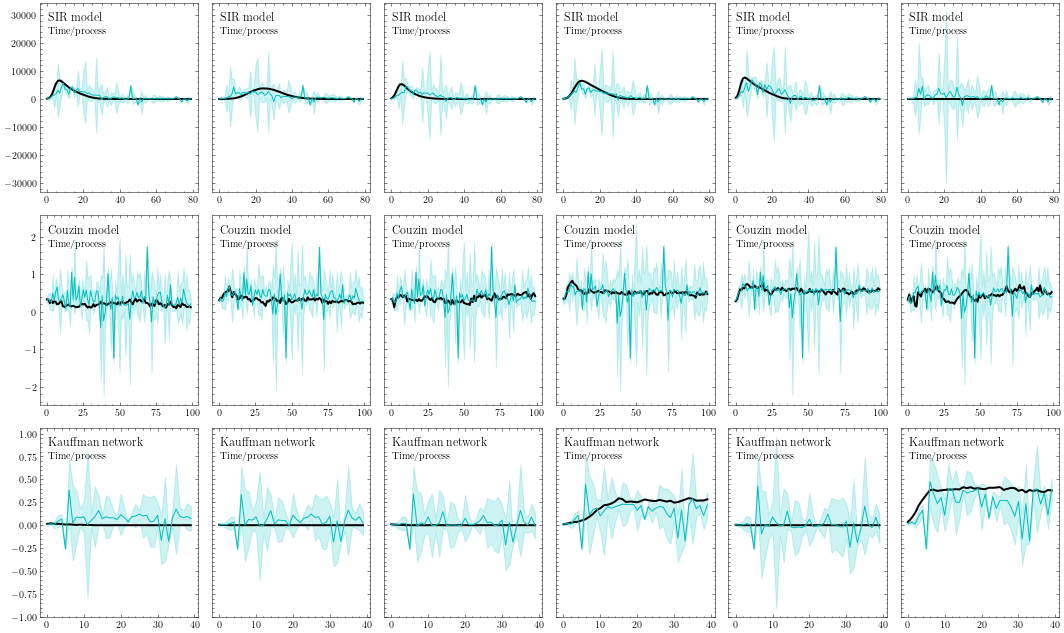

In [24]:
fig, axes = plt.subplots(3,6, figsize=(15,9),sharex='row', sharey='row')

for j, (tup, inputs_dict) in enumerate(igp_inputs.items()):
    tup_as_str    = str(tup)
    dataset, _, _ = tup
    axes_vec      = axes[j].ravel()

    forward = lambda x:  x * inputs_dict['scale'] +  inputs_dict['offset']

    mu    = test_preds[tup_as_str]['mu']
    sigma = test_preds[tup_as_str]['sigma']
    
    for i, ax in enumerate(axes_vec):
        true  = forward(inputs_dict['ys_test'][i])
        pred  = mu[:,i]

        plt.sca(ax)
        plt.plot(true, color='k', linewidth=2)
        plt.plot(pred, color='c')
        plt.fill_between(np.arange(pred.size), pred-2* sigma[:, i], pred+2* sigma[:, i], color='c', alpha=0.2)
        
        #ax.spines['right'].set_visible(False)
        #ax.spines['top'].set_visible(False)
        
        plt.text(0.05,0.95, FANCY_NAMES[dataset], ha='left', va='top', transform=ax.transAxes, fontsize=12)
        plt.text(0.05,0.875, 'Time/process', ha='left', va='top', transform=ax.transAxes)
        
plt.tight_layout()
plt.savefig('../figures/igp_series.png', dpi=400)

In [25]:
save_path  = '../outputs/independentgp/test_predictions.json'
test_preds = {detup(k):v for k,v in test_preds.items()}

with open(save_path, 'w') as outfile:
    json.dump(test_preds, outfile, cls=cli.NumpyEncoder)